In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from slam.gridmap import GridMap, LaserDataMatlab
from slam.utils import bresenham_line, vector2transform2D

In [3]:
plt.rcParams['figure.figsize'] = (15, 15)

c:\projects\slam-algorithms\src\slam\utils.py:19: RuntimeWarning: overflow encountered in exp
  return 1 - (1 / (1 + np.exp(l)))


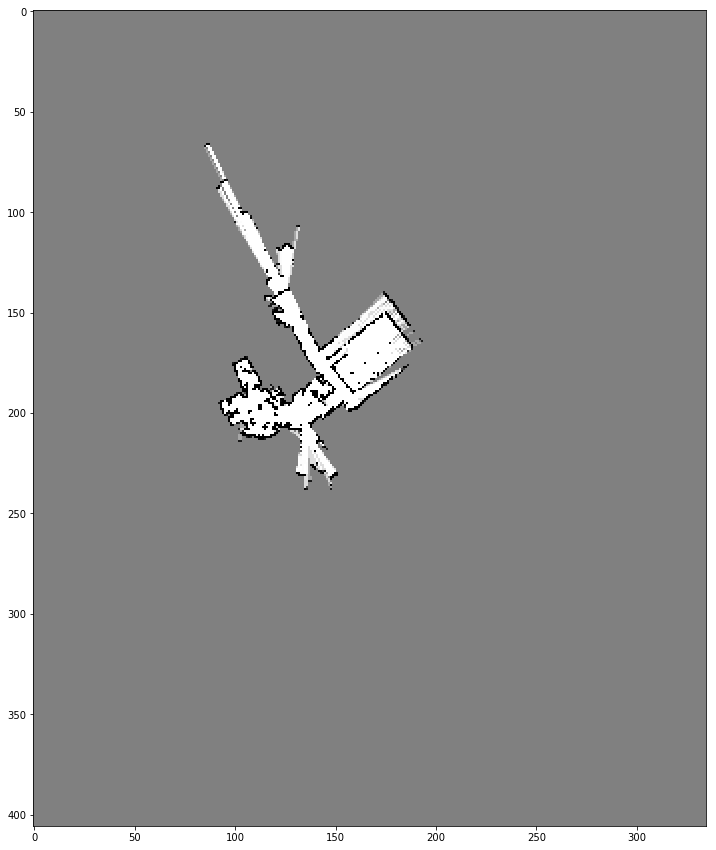

In [4]:
laser_data = LaserDataMatlab('./data/laser_struct.mat')
grid_map = GridMap(grid_size=0.3)
grid_map.init_from_laserdata(laser_data)

# Debug map
pose_list = laser_data.get_timestep_list()[:150]
# Full map (slow)
#pose_list = laser_data.get_timestep_list()
for t in pose_list:
    robot_pose = laser_data.get_pose(t)
    range_scan = laser_data.get_range_scan(t)
    grid_map.update(robot_pose, range_scan)
    
plt.imshow(grid_map.get_prob_map().T, cmap='gray', interpolation='nearest')

c:\projects\slam-algorithms\src\slam\utils.py:19: RuntimeWarning: overflow encountered in exp
  return 1 - (1 / (1 + np.exp(l)))


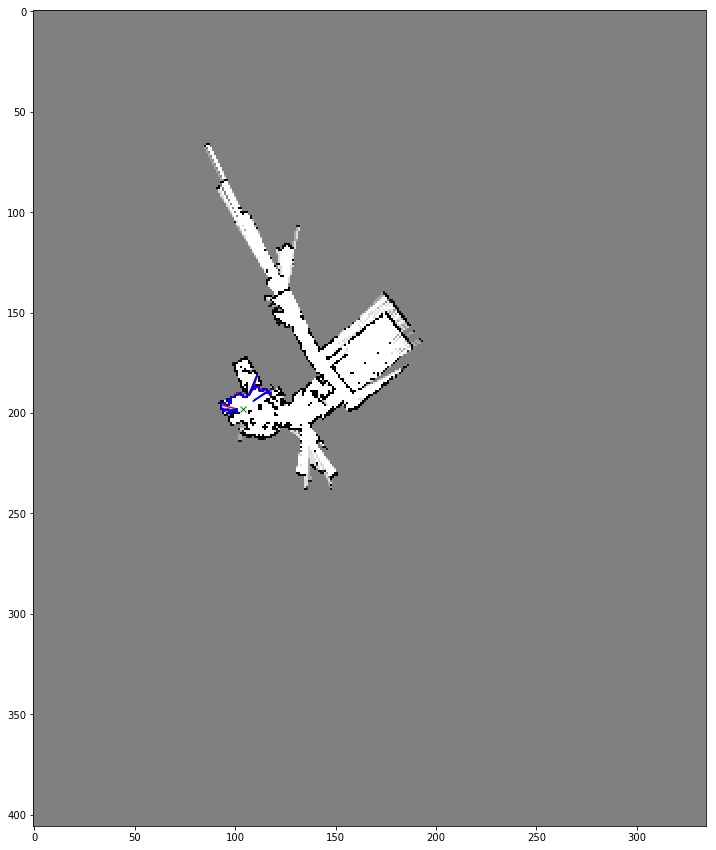

In [5]:
timestep = 25
laser_scan = laser_data.get_range_scan(timestep)
robot_pose = laser_data.get_pose(timestep)

max_range = 30
max_range = min(max_range, laser_scan['maximum_range'])
num_beams = len(laser_scan['ranges'])
start_angle = laser_scan['start_angle']
angular_res = laser_scan['angular_resolution']

scan_endpoints = GridMap.generate_laser_scan(max_range, num_beams, start_angle, angular_res)
raycasted = grid_map.raycast(robot_pose, scan_endpoints, 0.5)

points_x = []
points_y = []
for point in raycasted:
    x, y = point
    
    points_x.append(x)
    points_y.append(y)
    
robot_pose_map = GridMap.world_to_map_coordinates(
    robot_pose[0:2, :], grid_map._grid_size, grid_map._offset
)
rx = int(robot_pose_map.item(0))
ry = int(robot_pose_map.item(1))

robot_pose_trans = vector2transform2D(robot_pose)
real_laser_end = GridMap.laser_as_cartesian(laser_scan, 30)
real_laser_end = robot_pose_trans * real_laser_end
real_laser_map = GridMap.world_to_map_coordinates(
    real_laser_end[0:2, :], grid_map._grid_size, grid_map._offset
)

scan_x = []
scan_y = []
for col in range(real_laser_map.shape[1]):
    lx = int(real_laser_map.item((0, col)))
    ly = int(real_laser_map.item((1, col)))
    scan_x.append(lx)
    scan_y.append(ly)
    
plt.imshow(grid_map.get_prob_map().T, cmap='gray', interpolation='nearest')
plt.plot(rx, ry, 'gx')
plt.plot(points_x, points_y, 'r')
plt.plot(scan_x, scan_y, 'b')